In [87]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
import torch
import torch.optim as optim
from torch.autograd import Variable

import random
from typing import Callable
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [2]:
"""
Here we load the dataset, add gaussian,poisson,speckle

    'gauss'     Gaussian-distributed additive noise.
    'speckle'   Multiplicative noise using out = image + n*image,where
                n is uniform noise with specified mean & variance.
                
We define a function that adds each noise when called from main function
Input & Output: np array
                
"""

def add_noise(img, noise_type="gaussian", scale=0):
  row, col = 28, 28
  img = img.astype(np.float32)

  match noise_type:
    case "gaussian":
      mean  = 0
      var   = 0.01
      sigma = var**.5
      noise = np.random.normal(mean, sigma, img.shape)
      noise = noise.reshape(row, col)
      img   = img + (noise*scale)
      return img
     
    case "speckle" :
      noise = np.random.randn(row, col)
      noise = noise.reshape(row, col)
      img   = img + (img*noise*scale)
      return img
     
    case "salt_pepper" :
      prob=0.5
      output = img.copy()
      if len(img.shape) == 2:
          black = 0
          white = 1            
      probs = np.random.random(output.shape[:2])
      output[probs < (prob/2)] = black
      output[probs > 1 - (prob/2)] = white
      return output     
    case _:
      return img


In [3]:
mnist_ = mnist.load_data()

train_mask = (mnist_[0][1] == 1) | (mnist_[0][1] == 7)
test_mask = (mnist_[1][1] == 1) | (mnist_[1][1] == 7)

(xtrain, ytrain) = mnist_[0][0][train_mask], mnist_[0][1][train_mask]
(xtest, ytest) = mnist_[1][0][test_mask], mnist_[1][1][test_mask]

In [4]:
xtrain = np.array([minmax_scale(x) for x in xtrain])
xtest = np.array([minmax_scale(x) for x in xtest])

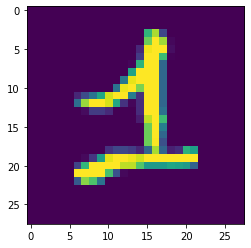

In [5]:
plt.imshow(xtrain[6].reshape((28, 28)))

In [6]:
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

No of training datapoints:13007
No of Test datapoints:2163


In [7]:
"""
From here onwards,we split the 60k training datapoints into 3 sets each given one type of each noise.
We shuffle them for better generalization.
"""
noises = ["gaussian", "speckle", "salt_pepper"]
noise_ct = 0
noise_id = 0
traindata = np.zeros((len(xtrain), 28, 28))


for idx in tqdm(range(len(xtrain))):
  if noise_ct < len(xtrain)/3:
    noise_ct += 1
    traindata[idx] = add_noise(xtrain[idx], noise_type=noises[noise_id], scale=1)
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0


print("\n{} noise addition completed to images".format(noises[noise_id])) 


noise_ct = 0
noise_id = 0
testdata = np.zeros((10000, 28, 28))

for idx in tqdm(range(len(xtest))):
  if noise_ct < len(xtest)/3:
    noise_ct += 1
    x = add_noise(xtest[idx], noise_type=noises[noise_id])
    testdata[idx] = x
    
  else:
    print("\n{} noise addition completed to images".format(noises[noise_id]))
    noise_id += 1
    noise_ct = 0

print("\n{} noise addition completed to images".format(noises[noise_id]))    
  

 22%|██▏       | 2856/13007 [00:00<00:00, 28549.82it/s]


gaussian noise addition completed to images


100%|██████████| 13007/13007 [00:00<00:00, 37589.12it/s]



speckle noise addition completed to images

salt_pepper noise addition completed to images


100%|██████████| 2163/2163 [00:00<00:00, 43696.77it/s]


gaussian noise addition completed to images

speckle noise addition completed to images

salt_pepper noise addition completed to images


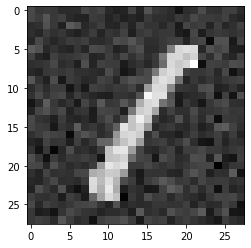

In [8]:
plt.imshow(traindata[0], cmap="gray")

Text(0.5, 1.0, 'Noised Image')

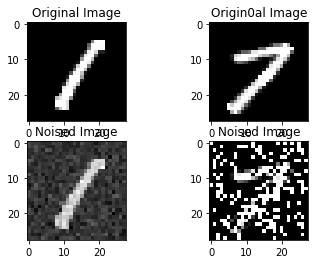

In [9]:
"""
Here we Try to visualize, each type of noise that was introduced in the images
Along with their original versions

"""

f, axes=plt.subplots(2,2)

#showing images with gaussian noise
axes[0,0].imshow(xtrain[0], cmap="gray")
axes[0,0].set_title("Original Image")
axes[1,0].imshow(traindata[0], cmap='gray')
axes[1,0].set_title("Noised Image")

#showing images with speckle noise
axes[0,1].imshow(xtrain[13000], cmap='gray')
axes[0,1].set_title("Origin0al Image")
axes[1,1].imshow(traindata[13000], cmap="gray")
axes[1,1].set_title("Noised Image")

In [10]:
class noisedDataset(Dataset):
  def __init__(self, 
               datasetnoised: np.ndarray, 
               datasetclean: np.ndarray, 
               labels: np.ndarray,
               transform: Callable):
    self.noise = datasetnoised
    self.clean = datasetclean
    self.labels = labels
    self.transform = transform
  
  def __len__(self):
    return len(self.noise)
  
  def __getitem__(self, idx):
    xNoise = self.noise[idx]
    xClean = self.clean[idx]
    y = self.labels[idx]
    
    if self.transform != None:
      xNoise = self.transform(xNoise)
      xClean = self.transform(xClean)

    return (xNoise, xClean, y)
    

In [11]:
tsfms = transforms.Compose([
    transforms.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [12]:
trainset.clean[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

In [13]:
"""
Here , we create the trainloaders and testloaders.
Also, we transform the images using standard lib functions
"""

batch_size = 32

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader  = DataLoader(testset, batch_size=1, shuffle=True)

In [14]:
"""
Here, we define the autoencoder model.
"""

class denoising_model(nn.Module):
  def __init__(self, hidden_layer_nb=1, hidden_size = 256, latent_size=64, img_size=28*28):
    super(denoising_model,self).__init__()

    encode_sequence_input = [nn.Linear(img_size, hidden_size), nn.ReLU()]
    encode_sequence_output = [nn.Linear(hidden_size, latent_size), nn.ReLU()]
    encode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      encode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      encode_sequence_hidden.append(nn.ReLU())

    encode_sequence = encode_sequence_input + encode_sequence_hidden + encode_sequence_output
        
    self.encoder = nn.Sequential(
      *encode_sequence
    )

    decode_sequence_input = [nn.Linear(latent_size, hidden_size), nn.ReLU()]
    decode_sequence_output = [nn.Linear(hidden_size, img_size), nn.Sigmoid()]
    decode_sequence_hidden = []
    for i in range(hidden_layer_nb):
      decode_sequence_hidden.append(nn.Linear(hidden_size, hidden_size))
      decode_sequence_hidden.append(nn.ReLU())

    decode_sequence = decode_sequence_input + decode_sequence_hidden + decode_sequence_output

    self.decoder = nn.Sequential(
      *decode_sequence
    )
 
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    
    return x

In [15]:
#We check whether cuda is available and choose device accordingly
if torch.cuda.is_available() == True:
  device = "cuda:0"
else:
  device = "cpu"

In [16]:
model = denoising_model(hidden_layer_nb=2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

In [17]:
print(model)

denoising_model(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=64, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [18]:
epochs = 120
l = len(trainloader)
losslist = list()
epochloss = 0
running_loss = 0
for epoch in range(epochs):
  break
  print("Entering Epoch: ", epoch)
  for dirty, clean, label in tqdm((trainloader)):
    
    
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
    dirty, clean = dirty.to(device), clean.to(device)

    optimizer.zero_grad()

    #-----------------Forward Pass----------------------
    output = model(dirty)
    loss = criterion(output, clean)

    #-----------------Backward Pass---------------------
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    epochloss += loss.item()
  #-----------------Log-------------------------------
  losslist.append(running_loss/l)
  running_loss = 0
  print("======> epoch: {}/{}, Loss:{}".format(epoch, epochs, loss.item()))
 

In [56]:
def train(model, optimizer, epochs, device, trainloader, testloader):
    model.train()
    for epoch in tqdm(range(epochs)):
        running_loss = 0
        for dirty, clean, label in trainloader:  
            
            dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
            clean = clean.view(clean.size(0), -1).type(torch.FloatTensor)
            dirty, clean = dirty.to(device), clean.to(device)

            optimizer.zero_grad()

            #-----------------Forward Pass----------------------
            output = model(dirty)
            loss = criterion(output, clean)

            #-----------------Backward Pass---------------------
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        #-----------------Log-------------------------------
        losslist.append(running_loss/l)


    true_error = 0
    for test in testset:
        true_error += mean_squared_error(test[0][0].flatten(), model(test[0].view(test[0].size(0), -1).type(torch.FloatTensor)).detach()[0])
    true_error /= len(testset)
    return true_error, losslist

In [57]:
train(model, optimizer, 120, device, trainloader, testdata)

100%|██████████| 120/120 [02:47<00:00,  1.40s/it]


(0.02437113009683372,
 [0.23747245198532171,
  0.23711888111340618,
  0.23676570254110293,
  0.23641423372144488,
  0.23606273030326758,
  0.23570892654121361,
  0.23535345707097863,
  0.23499386411627035,
  0.23463601642803125,
  0.23427121941668397,
  0.23390741474212534,
  0.2335326653294247,
  0.23315360589314443,
  0.2327675172825703,
  0.23236809334092995,
  0.23195935536807527,
  0.23153967305981263,
  0.23110638613782877,
  0.2306568021416957,
  0.23019258337466078,
  0.22971143198247623,
  0.22920839997415754,
  0.22868134198522685,
  0.22812920142450263,
  0.22754833501299124,
  0.22693602579670982,
  0.22628630163189234,
  0.22559598062635933,
  0.2248576510084349,
  0.22407355640971396,
  0.22322037713533538,
  0.2223031155453853,
  0.2213035240146979,
  0.2202094131005191,
  0.2190053228298042,
  0.21767117650561602,
  0.21617961522988077,
  0.21450055029966322,
  0.21259627870171896,
  0.2104117542651713,
  0.20788634475091752,
  0.2049238574885619,
  0.20141286525591587,

In [134]:
def gridsearch(model_obj: denoising_model, 
               parameters: dict,
               optimizer,
               learning_rate :int,
               epoch: int,
               device: str,
               trainloader: DataLoader,
               testdata):
    parameters = ParameterGrid(parameters)
    results = {}

    for i, params in enumerate(parameters):
        tmp_model = model_obj(**params)
        tmp_optim = optimizer(tmp_model.parameters(), lr=learning_rate)
        tmp_result = train(tmp_model, tmp_optim, epoch, device, trainloader, testdata)
        print(f"\tParams {i}/{len(parameters)} -> true error: {tmp_result[0]}")
        results[i] = {
            "params": params,
            "true_error": tmp_result[0],
            "training_error": tmp_result[1]
        }

    return results

In [135]:
parameters = {"hidden_layer_nb": range(1, 7, 2),
              "hidden_size": range(200, 501, 100),
              "latent_size": range(50, 201, 50)}

In [136]:
# results = gridsearch(denoising_model, parameters, optim.Adam, 1e-4, 50, device, trainloader, testdata)


100%|██████████| 50/50 [01:28<00:00,  1.78s/it]


	Params 0/48 -> true error: 0.019059343434922316


100%|██████████| 50/50 [01:39<00:00,  2.00s/it]


	Params 1/48 -> true error: 0.019113077925840074


100%|██████████| 50/50 [01:49<00:00,  2.20s/it]


	Params 2/48 -> true error: 0.01901577433414274


100%|██████████| 50/50 [01:39<00:00,  1.98s/it]


	Params 3/48 -> true error: 0.01907151392746266


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


	Params 4/48 -> true error: 0.01890767121934977


100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


	Params 5/48 -> true error: 0.018864219466959528


100%|██████████| 50/50 [02:13<00:00,  2.66s/it]


	Params 6/48 -> true error: 0.018934712698202988


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


	Params 7/48 -> true error: 0.01893240762853336


100%|██████████| 50/50 [02:30<00:00,  3.01s/it]


	Params 8/48 -> true error: 0.01883207526410986


100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


	Params 9/48 -> true error: 0.01885970995769492


100%|██████████| 50/50 [02:48<00:00,  3.36s/it]


	Params 10/48 -> true error: 0.018862959473937686


100%|██████████| 50/50 [02:50<00:00,  3.42s/it]


	Params 11/48 -> true error: 0.018883699007770847


100%|██████████| 50/50 [03:23<00:00,  4.08s/it]


	Params 12/48 -> true error: 0.01878433248672679


100%|██████████| 50/50 [03:32<00:00,  4.26s/it]


	Params 13/48 -> true error: 0.01878805809124242


100%|██████████| 50/50 [03:34<00:00,  4.30s/it]


	Params 14/48 -> true error: 0.018828170533554255


100%|██████████| 50/50 [03:18<00:00,  3.96s/it]


	Params 15/48 -> true error: 0.018860770104076316


100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


	Params 16/48 -> true error: 0.01970934004189305


100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


	Params 17/48 -> true error: 0.02003720328477786


100%|██████████| 50/50 [02:53<00:00,  3.47s/it]


	Params 18/48 -> true error: 0.019804446171130648


100%|██████████| 50/50 [02:38<00:00,  3.18s/it]


	Params 19/48 -> true error: 0.019864005183769032


100%|██████████| 50/50 [03:09<00:00,  3.79s/it]


	Params 20/48 -> true error: 0.01964508676461055


100%|██████████| 50/50 [03:24<00:00,  4.08s/it]


	Params 21/48 -> true error: 0.01962023357587412


100%|██████████| 50/50 [03:15<00:00,  3.92s/it]


	Params 22/48 -> true error: 0.019606743817344695


100%|██████████| 50/50 [03:37<00:00,  4.35s/it]


	Params 23/48 -> true error: 0.019681929396831187


100%|██████████| 50/50 [03:57<00:00,  4.75s/it]


	Params 24/48 -> true error: 0.019545264925105763


100%|██████████| 50/50 [04:08<00:00,  4.96s/it]


	Params 25/48 -> true error: 0.019501326883070807


100%|██████████| 50/50 [55:09<00:00, 66.20s/it]    


	Params 26/48 -> true error: 0.01951521416851325


100%|██████████| 50/50 [04:28<00:00,  5.38s/it]


	Params 27/48 -> true error: 0.019693748853705048


100%|██████████| 50/50 [05:49<00:00,  6.99s/it]


	Params 28/48 -> true error: 0.01949417136053962


100%|██████████| 50/50 [05:34<00:00,  6.69s/it]


	Params 29/48 -> true error: 0.019440252264385255


100%|██████████| 50/50 [05:45<00:00,  6.91s/it]


	Params 30/48 -> true error: 0.01934706714292058


100%|██████████| 50/50 [05:33<00:00,  6.67s/it]


	Params 31/48 -> true error: 0.019431209241514213


100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


	Params 32/48 -> true error: 0.02018991648518179


100%|██████████| 50/50 [03:04<00:00,  3.70s/it]


	Params 33/48 -> true error: 0.019867935902727382


100%|██████████| 50/50 [03:14<00:00,  3.90s/it]


	Params 34/48 -> true error: 0.019983576638174155


100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


	Params 35/48 -> true error: 0.020195315986965213


100%|██████████| 50/50 [04:20<00:00,  5.21s/it]


	Params 36/48 -> true error: 0.01998814718573913


100%|██████████| 50/50 [04:25<00:00,  5.31s/it]


	Params 37/48 -> true error: 0.019882626534854127


100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


	Params 38/48 -> true error: 0.02011073289068757


100%|██████████| 50/50 [04:29<00:00,  5.38s/it]


	Params 39/48 -> true error: 0.0197914718193237


100%|██████████| 50/50 [05:19<00:00,  6.39s/it]


	Params 40/48 -> true error: 0.019881785533489297


100%|██████████| 50/50 [05:26<00:00,  6.53s/it]


	Params 41/48 -> true error: 0.01977680500539861


100%|██████████| 50/50 [05:49<00:00,  7.00s/it]


	Params 42/48 -> true error: 0.019806948507600137


100%|██████████| 50/50 [05:54<00:00,  7.08s/it]


	Params 43/48 -> true error: 0.01971957284683019


100%|██████████| 50/50 [07:24<00:00,  8.89s/it]


	Params 44/48 -> true error: 0.01981130701186645


100%|██████████| 50/50 [08:01<00:00,  9.64s/it]


	Params 45/48 -> true error: 0.01973706402865778


100%|██████████| 50/50 [07:58<00:00,  9.57s/it]


	Params 46/48 -> true error: 0.019791343395766874


100%|██████████| 50/50 [07:53<00:00,  9.46s/it]


	Params 47/48 -> true error: 0.01994496028212144


In [1]:
with open("output_gridsearch.txt") as file:
    results = eval(file.read())

In [3]:
type(results)

dict

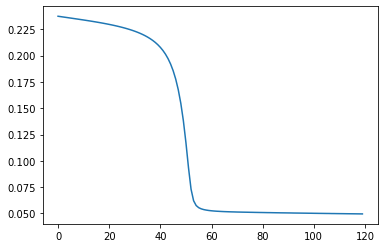

In [75]:
plt.plot(range(len(losslist)), losslist)

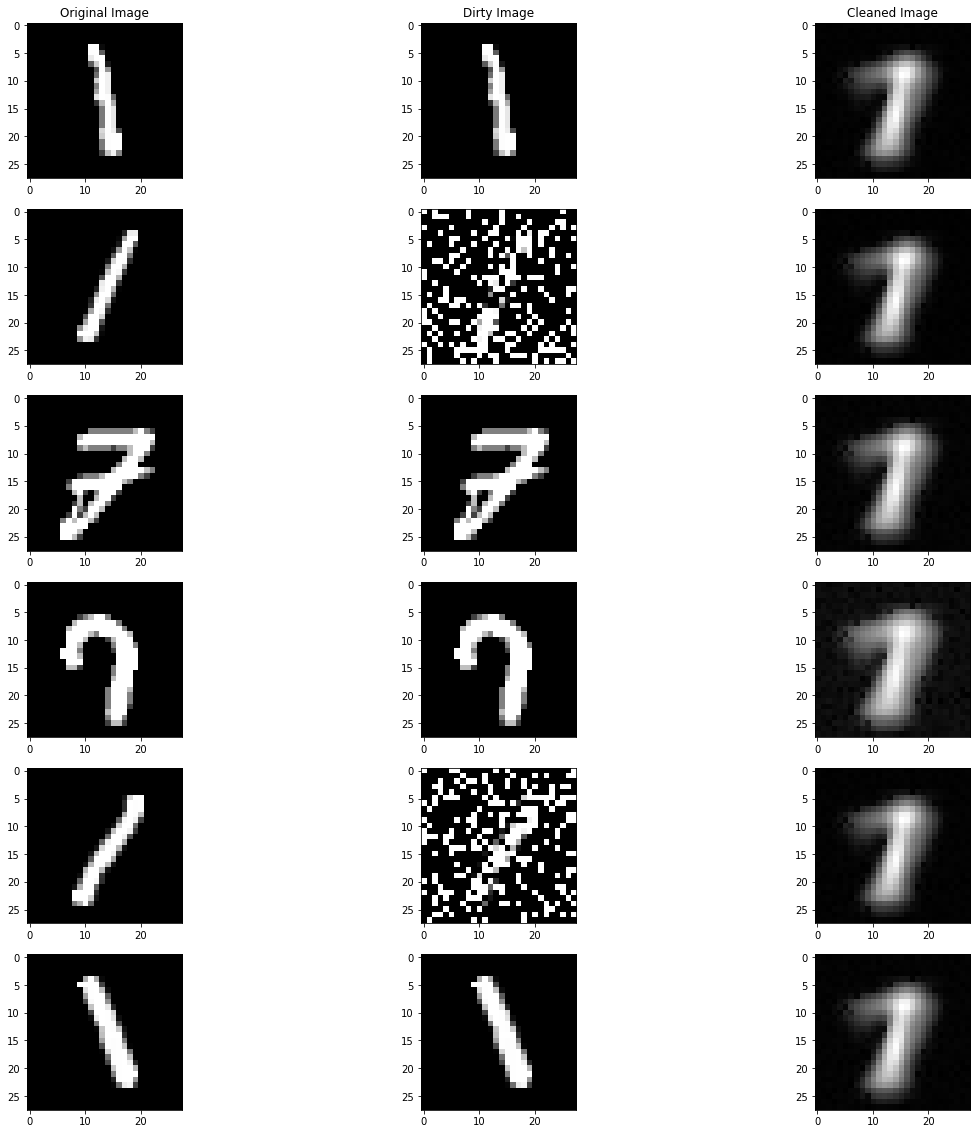

In [76]:
"""
Here, we try to visualize some of the results.
We randomly generate 6 numbers in between 1 and 10k , run them through the model,
and show the results with comparisons
"""
f,axes= plt.subplots(6,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

test_imgs=np.random.randint(0,len(xtest),size=6)
for idx in range((6)):
  dirty=testset[test_imgs[idx]][0]
  clean=testset[test_imgs[idx]][1]
  label=testset[test_imgs[idx]][2]
  dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
  dirty=dirty.to(device)
  output=model(dirty)
  
  output=output.view(1,28,28)
  output=output.permute(1,2,0).squeeze(2)
  output=output.detach().cpu().numpy()
  
  dirty=dirty.view(1,28,28)
  dirty=dirty.permute(1,2,0).squeeze(2)
  dirty=dirty.detach().cpu().numpy()
  
  clean=clean.permute(1,2,0).squeeze(2)
  clean=clean.detach().cpu().numpy()
  
  axes[idx,0].imshow(clean,cmap="gray")
  axes[idx,1].imshow(dirty,cmap="gray")
  axes[idx,2].imshow(output,cmap="gray")

In [ ]:
PATH = "model"
torch.save(model.state_dict(), PATH)  # We save the model state dict at PATH   